# Lesson 1 - Introduction to deep neural networks

> A first look at training deep neural networks to tag jets in proton-proton collisions.

## TODO

* Put dataset on the Hub with a loading script
* Figure out how to load `Dataset` objects in dataloaders
* Tidy up, add prose
* Add exercises
* Push model to Hub? => save for next lecture when we actually train from scratch
* Primer on N-subjettiness

## Learning objectives

* Understand what jet tagging is and how to frame it as a machine learning task
* Gain an introduction to the `fastai` library

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.

## Import libraries

In [2]:
import torch.nn.functional as F
from datasets import load_dataset
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [33]:
import datasets

datasets.logging.set_verbosity_error()

## A first look at 🤗 Datasets

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download and process the datasets that we'll encounter in this course. 🤗 Datasets provides smart caching and allows you to process larger-than-RAM datasets by exploiting a technique called _memory-mapping_ that provides a mapping between RAM and filesystem storage.

In [35]:
dataset_id = "lewtun/top_quark_tagging"
top_quark_ds = load_dataset(dataset_id, name="raw", split="train", streaming=True)

In [36]:
sample = list(top_quark_ds.take(5))
pd.DataFrame(sample)

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


As we can see, each row consists of 4-vectors $(E_i, p_{x_i}, p_{y_i}, p_{z_i})$ that correspond to the 200 particles that make up each jet. We also have an `is_signal_new` column that indicates whether the jet is a top signal (1) or QCD background (0).

## Representing jets as images

The first step in any machine learning problem is to decide how to represent the data.

In [27]:
jet_images_ds = load_dataset(dataset_id, name="image", split="train", streaming=True)

## Introducing fastai

## Physics-inspired representations

In [30]:
import datasets

In [31]:
datasets.logging.set_verbosity_error()

In [32]:
nsubjettiness_ds = load_dataset("lewtun/top_quark_tagging", name="nsubjettiness")
nsubjettiness_ds

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 1211000
    })
    validation: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 404000
    })
})

In [4]:
nsubj_dset

DatasetDict({
    train: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 1211000
    })
    validation: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 403000
    })
    test: Dataset({
        features: ['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'is_signal_new'],
        num_rows: 404000
    })
})

In [5]:
df = nsubj_dset["train"].to_pandas()

In [6]:
df.head()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
0,543.633972,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,0.000011,0.001115,0.000008,0
1,452.411865,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,0.000163,0.005454,0.000072,0
2,429.495270,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,0.001385,0.012678,0.000567,0
3,512.675415,0.102580,0.011369,0.000170,0.086306,0.007759,0.000071,0.068169,0.005386,0.000048,0.002376,0.000008,0
4,527.956848,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,0.004359,0.033249,0.003689,0


In [7]:
df["is_signal_new"].value_counts()

0    605523
1    605477
Name: is_signal_new, dtype: int64

In [8]:
train_df, test_df = train_test_split(df)

In [9]:
train_df.shape

(908250, 13)

In [10]:
test_df.shape

(302750, 13)

In [11]:
sample_df = train_df.sample(n=100_000, random_state=42)

In [12]:
sample_df["is_signal_new"].value_counts()

0    50119
1    49881
Name: is_signal_new, dtype: int64

## Create data loaders

In [57]:
num_nsubs = 12
df = sample_df.copy().iloc[:, :num_nsubs]
df["is_signal_new"] = sample_df["is_signal_new"]

In [58]:
df.head()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
1026210,479.063812,0.310177,0.101835,0.012916,0.196055,0.045657,0.003527,0.136678,0.027206,0.001930,0.023713,0.001604,0
227019,463.405304,0.671508,0.432267,0.189239,0.349260,0.133150,0.028599,0.331222,0.118289,0.021855,0.085024,0.011871,0
226787,499.995911,0.418122,0.198203,0.059161,0.262924,0.092493,0.018761,0.149115,0.026247,0.001232,0.016727,0.000715,1
707147,401.752899,0.487714,0.248380,0.074418,0.253256,0.083177,0.012901,0.156960,0.029310,0.001670,0.023750,0.001465,1
967904,512.614868,0.388887,0.164299,0.039343,0.223234,0.071823,0.012899,0.109464,0.016495,0.000852,0.013099,0.000413,1


In [59]:
splits = RandomSplitter(valid_pct=0.10)(range_of(df))

In [60]:
splits

((#90000) [47169,40327,17715,5113,15391,76520,10887,84566,15307,45728...],
 (#10000) [29543,10667,30184,41636,79131,90910,52348,36557,96242,8849...])

In [65]:
features = list(df.drop(columns="is_signal_new").columns)

In [64]:
features

Index(['tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2',
       'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2'],
      dtype='object')

In [66]:
to = TabularPandas(df, cont_names=features, y_names="is_signal_new", splits=splits)

In [67]:
to.show()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new
870243,425.258331,0.262766,0.077909,0.009779,0.151154,0.030219,0.002032,0.133879,0.021652,0.000892,0.014752,0.000513,0
424756,491.383759,0.343328,0.135804,0.037844,0.296186,0.102910,0.027207,0.166867,0.034594,0.002449,0.014581,0.000504,1
404253,455.071960,0.566451,0.316813,0.102833,0.381245,0.180418,0.052161,0.239080,0.064503,0.006300,0.048405,0.004254,1
587916,501.690613,0.138641,0.022436,0.001114,0.125445,0.017946,0.000759,0.085202,0.012484,0.000674,0.005226,0.000059,0
964448,555.198486,0.253607,0.066551,0.005291,0.082110,0.014195,0.000909,0.060538,0.007547,0.000185,0.004181,0.000098,0
119077,491.414032,0.218393,0.066413,0.013453,0.167236,0.039313,0.006338,0.093534,0.012655,0.000442,0.007977,0.000319,0
671893,436.721039,0.327883,0.113820,0.015816,0.238744,0.062941,0.005393,0.203141,0.044487,0.002454,0.030946,0.001418,0
318953,570.456177,0.141271,0.024355,0.004034,0.072058,0.012487,0.003559,0.039536,0.002516,0.000060,0.000998,0.000005,0
443008,475.071655,0.484021,0.237143,0.064709,0.282018,0.096827,0.019375,0.242246,0.065051,0.006862,0.043286,0.002306,1
402288,475.740631,0.290354,0.092654,0.010618,0.131698,0.025809,0.001265,0.063928,0.006683,0.000144,0.004380,0.000130,1


In [68]:
dls = to.dataloaders(1000)

In [22]:
dls = TabularDataLoaders.from_df(
    df, y_names="is_signal_new", bs=1000, y_block=CategoryBlock, splits=splits
)

In [63]:
dls.show_batch()

,tau_1_0.5,is_signal_new
0,416.841309,1
1,471.361115,1
2,472.899231,1
3,500.551239,0
4,388.773621,1
5,466.322662,1
6,427.646454,0
7,482.396698,0
8,457.188538,0
9,524.644836,0


In [64]:
learn = tabular_learner(dls, layers=[100, 100], metrics=[accuracy, RocAucBinary()])

In [65]:
learn.summary()

TabularModel (Input shape: 1000 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1000 x 1            
BatchNorm1d                               2          True      
____________________________________________________________________________
                     1000 x 100          
Linear                                    100        True      
ReLU                                                           
BatchNorm1d                               200        True      
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     1000 x 2            
Linear                                    202        True      
____________________________________________________________________________

Total params: 10,704
Total tr

SuggestedLRs(valley=0.0005754399462603033)

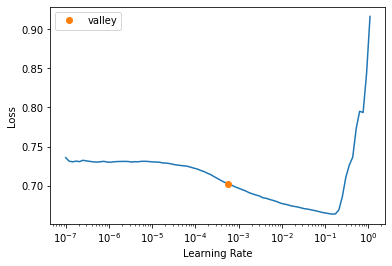

In [66]:
learn.lr_find()

In [67]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.636885,0.634588,0.630300,0.679790,00:00
1,0.631322,0.633433,0.630250,0.679742,00:00
2,0.630294,0.633258,0.631400,0.679765,00:00


In [41]:
learn.show_results()

,tau_3_0.5,tau_1_2,tau_2_1,tau_2_0.5,tau_3_1,tau_1_0.5,tau_3_2,tau_4_1,tau_2_2,tau_4_2,tau_4_0.5,tau_1_1,is_signal_new,is_signal_new_pred
0,0.000199,0.026193,0.082578,0.005510,0.080710,487.056671,0.008006,0.006150,0.008889,0.000110,0.000149,0.134117,0.0,0.0
1,0.064124,0.229138,0.329566,0.083129,0.269105,434.199738,0.092155,0.036366,0.160868,0.002240,0.016188,0.447756,1.0,1.0
2,0.003316,0.035023,0.132484,0.004138,0.082880,464.514801,0.009490,0.004635,0.027569,0.000060,0.000263,0.162971,0.0,0.0
3,0.002106,0.379804,0.163855,0.145976,0.126397,464.145264,0.022298,0.020459,0.033400,0.000899,0.001213,0.615980,0.0,0.0
4,0.000942,0.034224,0.105502,0.002022,0.028275,514.938110,0.002068,0.001149,0.019873,0.000005,0.000021,0.168923,0.0,0.0
5,0.028222,1.612831,0.345245,8.638166,0.181819,479.295807,0.041613,0.032430,0.137961,0.001908,0.003326,0.953868,1.0,1.0
6,0.019596,0.238392,0.349460,0.069123,0.139050,491.283813,0.022211,0.014399,0.129482,0.000334,0.000884,0.476079,1.0,1.0
7,0.007551,0.077920,0.190812,0.010909,0.138200,466.086884,0.028700,0.019405,0.053513,0.000881,0.001844,0.255459,0.0,0.0
8,0.009243,0.266048,0.293930,0.074713,0.158475,428.074707,0.038499,0.015913,0.089876,0.000428,0.003127,0.513716,1.0,1.0


In [42]:
test_dl = learn.dls.test_dl(test_df)

In [43]:
preds = learn.get_preds(dl=test_dl)

In [44]:
rc = roc_curve(test_df["is_signal_new"], preds[0][:, 1])

In [45]:
len(rc)

3

In [46]:
rc[0].shape

(60735,)

In [47]:
rc[1].shape

(60735,)

In [48]:
rc[2].shape

(60735,)

(0.0, 1.0)

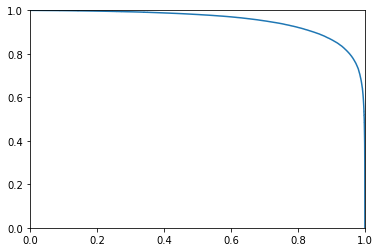

In [49]:
plt.plot(rc[1], 1 - rc[0], "-")
plt.xlim(0, 1)
plt.ylim(0, 1)

## Try with Tabular model

In [14]:
model.eval()

Sequential(
  (0): Linear(in_features=12, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)

In [90]:
emb_szs = []
m = TabularModel(emb_szs, n_cont=12, out_sz=2, layers=[100, 100]).eval()

In [98]:
inputs.shape

torch.Size([12])

In [101]:
inputs.dim()

1

In [89]:
tab_learn = TabularLearner(dls, m, metrics=[accuracy, RocAucBinary()])

SuggestedLRs(valley=0.0012022644514217973)

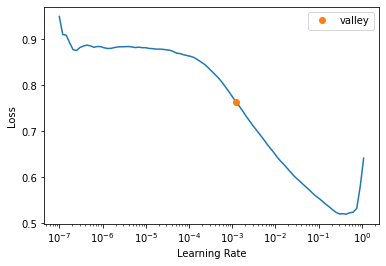

In [93]:
tab_learn.lr_find()

In [94]:
tab_learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.388897,0.293609,0.872350,0.944520,00:00
1,0.307618,0.281418,0.877400,0.949350,00:00
2,0.289134,0.279580,0.878250,0.949996,00:00


## Try with PyTorch model

In [39]:
nsubs = 12
model = nn.Sequential(
    nn.Linear(nsubs, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 2)
)

In [16]:
inputs = train_df.iloc[0, :-1]
inputs = torch.from_numpy(np.array(inputs)).float()
model.forward(inputs)

tensor([4.4080, 9.1261], grad_fn=<AddBackward0>)

In [23]:
mm = Learner(
    dls, model, loss_func=F.nll_loss, opt_func=SGD, metrics=[accuracy, RocAucBinary()]
)

In [24]:
mm.lr_find()

TypeError: forward() takes 2 positional arguments but 3 were given

## Down to here

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from datasets import Dataset
from huggingface_hub import PyTorchModelHubMixin
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader, TensorDataset

## Load data

In [ ]:
EVENTS_PATH = "data/QG_nsubs.npz?dl=1"

with np.load(EVENTS_PATH) as f:
    X, y = f["X"], f["y"]

In [ ]:
X.shape, y.shape

((100000, 45), (100000,))

In [ ]:
data = {f"feature_{idx}": X[:, idx] for idx in range(45)}

In [ ]:
data["label"] = y

In [ ]:
df = pd.DataFrame(data)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,label
0,0.582885,0.359834,0.159466,0.286434,0.109313,0.031360,0.291994,0.104627,0.025298,0.269625,...,0.191827,0.045562,0.004745,0.183424,0.042593,0.004490,0.174668,0.039015,0.004060,0.0
1,0.260756,0.084642,0.019812,0.240676,0.073122,0.015786,0.225725,0.063897,0.012387,0.215447,...,0.126111,0.021134,0.002316,0.122458,0.018581,0.001079,0.117416,0.017345,0.000992,0.0
2,0.564012,0.330684,0.127177,0.292710,0.110119,0.024787,0.258846,0.086578,0.017215,0.240176,...,0.150572,0.034919,0.003328,0.147431,0.032971,0.003017,0.143079,0.031147,0.002829,0.0
3,0.395935,0.170801,0.042085,0.344588,0.130606,0.026208,0.271026,0.090233,0.017891,0.243731,...,0.164546,0.034850,0.004036,0.151774,0.029703,0.002897,0.149630,0.028986,0.002850,0.0
4,0.196304,0.051556,0.011701,0.192528,0.048644,0.010743,0.178389,0.043404,0.009060,0.172218,...,0.084400,0.012952,0.001005,0.078391,0.011012,0.000815,0.076849,0.010029,0.000572,0.0


In [ ]:
# Can't use categorical
dset = Dataset.from_pandas(df)
dset

Dataset({
    features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'label'],
    num_rows: 100000
})

In [ ]:
X.shape

(100000, 45)

In [ ]:
y.shape

(100000,)

In [ ]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [ ]:
num_nsubs = 1
X = X[:, :num_nsubs]

In [ ]:
X_train, X_val, X_test = X[:75_000], X[75_000:85_000], X[85_000:]
y_train, y_val, y_test = y[:75_000], y[75_000:85_000], y[85_000:]

In [ ]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
test_ds = TensorDataset(X_test, y_test)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=100)
test_dl = DataLoader(test_ds, batch_size=100)

## Define model

In [ ]:
class DNNModel(LightningModule):
    def __init__(self, nsubs=45):
        super().__init__()
        self.nsubs = nsubs
        self.accuracy = torchmetrics.Accuracy()
        self.roc_auc = torchmetrics.AUROC(num_classes=2)
        self.layers = nn.Sequential(
            nn.Linear(self.nsubs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
        )

    def forward(self, batch):
        x, y = batch
        x = self.layers(x.view(x.size(0), -1))
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.roc_auc(y_hat, y)
        self.log("val_accuracy", self.accuracy, on_epoch=True, prog_bar=True)
        self.log(
            "val_roc_auc",
            self.roc_auc,
            on_epoch=True,
        )
        self.log(
            "val_loss",
            val_loss,
            on_epoch=True,
        )

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.accuracy(y_hat, y)
        self.roc_auc(y_hat, y)
        self.log("test_accuracy", self.accuracy, on_epoch=True, prog_bar=True)
        self.log(
            "test_roc_auc",
            self.roc_auc,
            on_epoch=True,
        )
        self.log(
            "test_loss",
            val_loss,
            on_epoch=True,
        )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def train_dataloader(self):
        return train_dl

    def val_dataloader(self):
        return valid_dl

    def test_dataloader(self):
        return test_dl

In [ ]:
batch = next(iter(test_dl))

In [ ]:
model = DNNModel(nsubs=1)

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [ ]:
model(batch).shape

torch.Size([100, 2])

In [ ]:
model.summarize()

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary.py:471: LightningDeprecationWarning: Argument `mode` in `LightningModule.summarize` is deprecated in v1.4 and will be removed in v1.6. Use `max_depth=1` to replicate `mode=top` behavior.
  rank_zero_deprecation(


  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | roc_auc  | AUROC      | 0     
2 | layers   | Sequential | 10.5 K
----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)

In [ ]:
trainer = Trainer(
    gpus=1,
    max_epochs=10,
    # auto_lr_find=True
    # progress_bar_refresh_rate=100,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | roc_auc  | AUROC      | 0     
2 | layers   | Sequential | 10.5 K
----------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/dl4phys/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.6751999855041504,
 'test_loss': 0.5903524160385132,
 'test_roc_auc': 0.7281567454338074}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.6751999855041504,
  'test_roc_auc': 0.7281567454338074,
  'test_loss': 0.5903524160385132}]

In [ ]:
preds = trainer.predict(model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
len(preds)

150

In [ ]:
preds_np = np.vstack(preds)

In [ ]:
preds_np.shape

(15000, 2)

In [ ]:
y_test.numpy().shape

(15000,)

In [ ]:
preds[0][0]

tensor([-0.5266, -0.8931])

In [ ]:
roc_auc_score(y_test, preds_np[:, 1])

0.7281606545078303

In [ ]:
rc = roc_curve(y_test, preds_np[:, 1])

In [ ]:
len(rc)

3

In [ ]:
rc[0].shape

(6252,)

In [ ]:
rc[1].shape

(6252,)

In [ ]:
rc[2].shape

(6252,)

(0.0, 1.0)

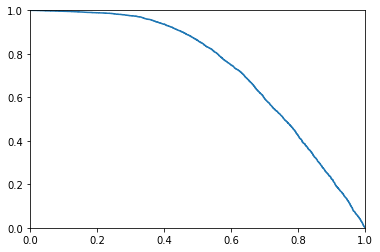

In [ ]:
plt.plot(rc[1], 1 - rc[0], "-")
plt.xlim(0, 1)
plt.ylim(0, 1)

## With fastai

In [ ]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,label
0,0.582885,0.359834,0.159466,0.286434,0.109313,0.031360,0.291994,0.104627,0.025298,0.269625,...,0.191827,0.045562,0.004745,0.183424,0.042593,0.004490,0.174668,0.039015,0.004060,0.0
1,0.260756,0.084642,0.019812,0.240676,0.073122,0.015786,0.225725,0.063897,0.012387,0.215447,...,0.126111,0.021134,0.002316,0.122458,0.018581,0.001079,0.117416,0.017345,0.000992,0.0
2,0.564012,0.330684,0.127177,0.292710,0.110119,0.024787,0.258846,0.086578,0.017215,0.240176,...,0.150572,0.034919,0.003328,0.147431,0.032971,0.003017,0.143079,0.031147,0.002829,0.0
3,0.395935,0.170801,0.042085,0.344588,0.130606,0.026208,0.271026,0.090233,0.017891,0.243731,...,0.164546,0.034850,0.004036,0.151774,0.029703,0.002897,0.149630,0.028986,0.002850,0.0
4,0.196304,0.051556,0.011701,0.192528,0.048644,0.010743,0.178389,0.043404,0.009060,0.172218,...,0.084400,0.012952,0.001005,0.078391,0.011012,0.000815,0.076849,0.010029,0.000572,0.0


In [ ]:
df["label"].nunique()

2

In [ ]:
from fastai.tabular.all import *